In [0]:
import os, random, gc, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
import keras_preprocessing.image
import tensorflow.keras.backend as k
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Input, AvgPool2D, Conv2D
from tensorflow.keras.layers import multiply, concatenate, Lambda, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
from PIL import Image
from google.colab import drive

In [2]:
!ls

sample_data


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Hello Google Drive!

In [4]:
is_pretrained = True
con_training = True # Adam -> SGD
batch_size = 32
width = 360
height = 270
learning_rate = 1e-3

print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 1.14.0


In [0]:
#os.environ['KAGGLE_USERNAME'] = "$USER_NAME"
#os.environ['KAGGLE_KEY'] = "$KEY"
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [6]:
!unzip '/content/drive/My Drive/Colab Notebooks/chest-xray-pneumonia.zip' -d chest-xray-pneumonia

Archive:  /content/drive/My Drive/Colab Notebooks/chest-xray-pneumonia.zip
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/._chest_xray  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-

In [0]:
#!rm -rf chest-xray-pneumonia.zip
#!rm -rf chest-xray-pneumonia
#!rm -rf chest-xray-pneumonia-dataset/__MACOSX

In [0]:
# Creates directory if directory exists 
# removes directory (to create new one) if remove parameter is set to True
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

In [0]:
def dir_file_count(directory):
  total_files = 0
  for root, dirs, files in os.walk(".", topdown=False):
    total_files += len(list(filter(lambda x: x.endswith('.jpeg'), files)))
  return total_files

def xray_process(im):
  # X-Rays are negative images. Imagenet was trained on normal images.
  im = 255. - im

  # Imagenet tensorflow samples are scaled between -1 (black) and 1 (white)
  # https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  im /= 255.
  im -= .5
  im *= 2.
  return im

target_size = (height, width)
class_mode = 'categorical'
training_dir = '/content/chest-xray-pneumonia/chest_xray/train'
testing_dir = '/content/chest-xray-pneumonia/chest_xray/test'



In [10]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=xray_process)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    interpolation='lanczos',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

Found 5216 images belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(
                                  fill_mode='nearest',
                                  preprocessing_function=xray_process)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    interpolation='lanczos',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=False)

Found 624 images belonging to 2 classes.


In [0]:
#@title Default title text
# print date and time for given type of representation
def date_time(x):
  if x==1:
      return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
  if x==2:    
      return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
  if x==3:  
      return 'Date now: %s' % datetime.datetime.now()
  if x==4:  
      return 'Date today: %s' % datetime.date.today()

In [0]:
# prints an integer for debugging
def debug(x):
  print("-"*40, x, "-"*40)

In [0]:
# Removes everything except alphabetical and 
# selected characters from name string
def name_correct(name):
  return re.sub(r'[a-zA-Z,:', ' ', name).title()

In [0]:
def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", 
                          legends=[], title_fontsize=18, label_fontsize=14, 
                          image_file_name="", save=False, dpi=100, 
                          update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

In [0]:
def select_image_by_category(image_dir, image_count_per_category):
    print(image_dir)
    classes = os.listdir(image_dir)
    print(classes)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths # gives you i lists of j image filepaths

def get_fig_axes(subplot_params):
  fig, axes = plt.subplots(
      nrows=subplot_params["nrows"], ncols=subplot_params["ncols"],
      figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
      dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
      edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])

  return fig, axs

## Shows images with the filename on top
def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])

    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()

# Output: Number of Classes, Class 1 images, Class 2 images, ... Class n images.
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
  class_count = len(os.listdir(directory)) # number of classes
  print("Number of Class: ", class_count)
  sample_img_by_class = select_image_by_category(directory, image_count_per_category)
  for class_name in sample_img_by_class:
    plot_params = get_reset_plot_params(image_file_name="img.png", save=save, dpi=dpi, update_image=update_image)
    subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
    print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
    plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
    print("")
  print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [0]:
#!cp /content/chest-xray-pneumonia.zip '/content/drive/My Drive/Colab Notebooks'

In [0]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [0]:
# reset tensorflow graph to free up memory and resource allocation
def reset_graph(model=None):
  if model:
    try:
      del model
    except:
      return False

  tf.reset_default_graph()
  gc.collect()

  return True

# reset callbacks
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
  checkpoint = None
  reduce_lr = None
  early_stopping = None
  tensorboard = None
  

In [0]:
def get_image_set(image_set, image_type):
  def get_image_path(path_pre, image_name):
    return '{}/{}/{}/{}'.format(path_pre, image_set, image_type, image_name)

  path_pre = '/content/chest-xray-pneumonia/chest_xray'
  image_list = os.listdir('{}/{}/{}'.format(path_pre, image_set, image_type))
  image_list = list(map(lambda x: get_image_path(path_pre, x), image_list))

  # Ignore .DS_Store files
  image_list = list(filter(lambda x: x.endswith('.jpeg'), image_list))
  return image_list

tr_normal = get_image_set('train', 'NORMAL')
tr_pneumonia = get_image_set('train', 'PNEUMONIA')

te_normal = get_image_set('test', 'NORMAL')
te_pneumonia = get_image_set('test', 'PNEUMONIA')

images_normal = tr_normal + te_normal
images_pneumonia = tr_pneumonia + te_pneumonia
images_pneumonia_bacterial = [img for img in images_pneumonia
                              if img.split('/')[-1].split('_')[1] == 'bacteria']
images_pneumonia_viral = [img for img in images_pneumonia
                          if img.split('/')[-1].split('_')[1] == 'virus']

images_full = images_normal + images_pneumonia
images_test = te_normal + te_pneumonia

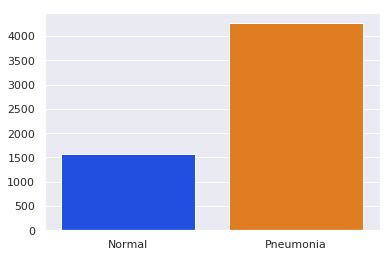

In [21]:
sns.set(style="darkgrid", palette="bright")
sns.barplot(x=['Normal', 'Pneumonia'],
            y=[len(images_normal),
               len(images_pneumonia)])

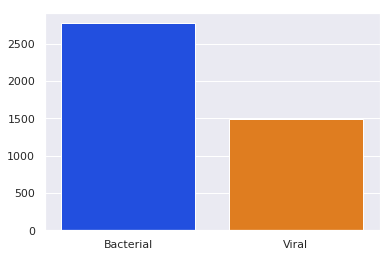

In [22]:
sns.set(style="darkgrid", palette="bright")
sns.barplot(x=['Bacterial', 'Viral'],
            y=[len(images_pneumonia_bacterial),
               len(images_pneumonia_viral)])

In [23]:
def get_weight(y):
    class_weight_current = class_weight.compute_class_weight('balanced',
                                                             np.unique(y), y)
    return class_weight_current

class_w = get_weight(train_generator.classes)
print(class_w)

[1.9448173  0.67303226]


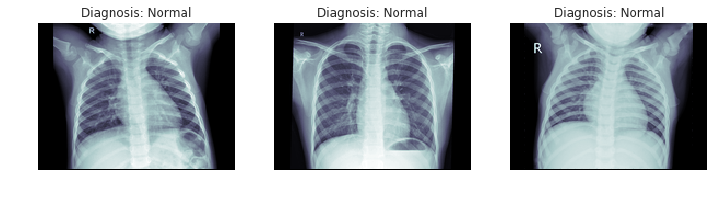

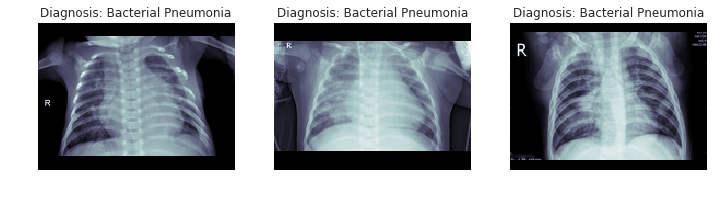

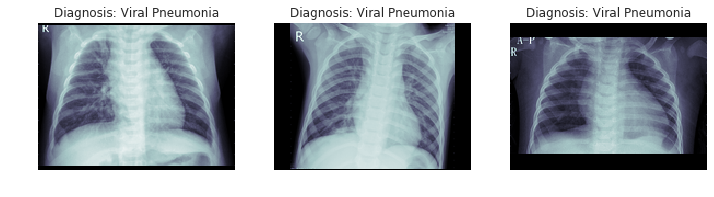

In [24]:
def get_image(path):
  return cv2.imread(path, 0)

def get_resized_image(path, width, height):
  im = Image.fromarray(get_image(path))
  im_w, im_h = im.size

  # Proportionally scale to be contained within canvas bounds.
  if im_w > width:
    im_h = int(width/im_w * im_h)
    im_w = width
  if im_h > height:
    im_w = int(height/im_h * im_w)
    im_h = height

  if [im_w, im_h] != list(im.size):
    im.thumbnail((im_w, im_h), Image.ANTIALIAS)

  # Return the image over a black background.    
  im_resized = Image.new('RGB', (width, height), (0, 0, 0))
  offset = ((width - im.size[0]) // 2,
            (height - im.size[1]) // 2)
  im_resized.paste(im, offset)

  return np.array(im_resized)

def plot_sample_xrays(image_set, image_label,
                      width=width//2, height=height//2,
                      rows=1, cols=3,
                      size_w=4, size_h=3):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  for idx in range(rows*cols):
    i = random.randint(0, len(image_set))
    im = get_resized_image(image_set[i], width, height)[:, :, 0]
    ax[idx%cols].imshow(im, cmap='bone')
    ax[idx%cols].axis('off')
    ax[idx%cols].set_title('Diagnosis: {}'.format(image_label))
  plt.show()

plot_sample_xrays(images_normal, 'Normal')
plot_sample_xrays(images_pneumonia_bacterial, 'Bacterial Pneumonia')
plot_sample_xrays(images_pneumonia_viral, 'Viral Pneumonia')

In [0]:
# Pre-training on Grayscale ImageNet Improves Medical Image Classification
# https://link.springer.com/chapter/10.1007/978-3-030-11024-6_37
# (src) https://github.com/RohitSaha/VGG_Imagenet_Weights_GrayScale_Images/blob/master/convert_vgg_grayscale.py

def VGG16_bw():
	model = VGG16(weights='imagenet', include_top=False)
	block1_conv1 = model.get_layer('block1_conv1').get_weights()
	weights, biases = block1_conv1

	weights = np.transpose(weights, (3, 2, 0, 1))
	kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape
	grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

	for i in range(kernel_out_channels):
		get_kernel = weights[i, :, :, :]
		temp_kernel = np.zeros((3, 3))
		in_channels, in_rows, in_columns = get_kernel.shape

		for in_row in range(in_rows):
			for in_col in range(in_columns):
				feature_red = get_kernel[0, in_row, in_col]
				feature_green = get_kernel[1, in_row, in_col]
				feature_blue = get_kernel[2, in_row, in_col]

				total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)
				temp_kernel[in_row, in_col] = total

		temp_kernel = np.expand_dims(temp_kernel, axis=0)
		grayscale_weights[i, :, :, :] = temp_kernel

	grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0))
	new_block1_conv1 = [grayscale_weights, biases]
	vgg16_weights = {}
	for layer in model.layers[2:]:
		if "conv" in layer.name:
			vgg16_weights["vgg16bw_" + layer.name] = model.get_layer(layer.name).get_weights()

	del model

	# Custom build VGG16

	vgg16_bw_input = Input(shape=(height, width, 1), name='vgg16bw_input')
	# Block 1
	x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(height, width, 1), data_format="channels_last", name='vgg16bw_block1_conv1')(vgg16_bw_input)
	x = Conv2D(64, (3, 3), activation='relu', padding='same', name='vgg16bw_block1_conv2')(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block1_pool')(x)

	# Block 2
	x = Conv2D(128, (3, 3), activation='relu', padding='same', name='vgg16bw_block2_conv1')(x)
	x = Conv2D(128, (3, 3), activation='relu', padding='same', name='vgg16bw_block2_conv2')(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block2_pool')(x)

	# Block 3
	x = Conv2D(256, (3, 3), activation='relu', padding='same', name='vgg16bw_block3_conv1')(x)
	x = Conv2D(256, (3, 3), activation='relu', padding='same', name='vgg16bw_block3_conv2')(x)
	x = Conv2D(256, (3, 3), activation='relu', padding='same', name='vgg16bw_block3_conv3')(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block3_pool')(x)

	# Block 4
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block4_conv1')(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block4_conv2')(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block4_conv3')(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block4_pool')(x)

	# Block 5
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block5_conv1')(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block5_conv2')(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block5_conv3')(x)
	x = MaxPooling2D((8, 8), strides=(8, 8), name='vgg16bw_block5_pool')(x)

	vgg16_bw = Model(inputs=vgg16_bw_input, outputs=x)

	vgg16_bw.get_layer('vgg16bw_block1_conv1').set_weights(new_block1_conv1)
	for layer in vgg16_bw.layers[2:]:
		if 'conv' in layer.name:
			vgg16_bw.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

	return vgg16_bw

In [0]:
def pay_attention(m_input, name):
  # Based on https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age#Attention-Model
  pt_depth = 512
  bn_features = BatchNormalization()(m_input)

  attn = Conv2D(64, kernel_size=(1,1), padding='same', activation='relu')(bn_features)
  attn = Conv2D(16, kernel_size=(1,1), padding='same', activation='relu')(attn)
  attn = Conv2D(1, 
                kernel_size=(1,1), 
                padding='valid', 
                activation='sigmoid',
                name=name)(attn)
  up_c2_w = np.ones((1, 1, 1, pt_depth))
  up_c2 = Conv2D(pt_depth,
                 kernel_size=(1,1),
                 padding='same', 
                 activation='linear',
                 use_bias=False,
                 weights=[up_c2_w])
  up_c2.trainable = False
  attn = up_c2(attn)

  mask_features = multiply([attn, bn_features])
  gap_features = GlobalAveragePooling2D()(mask_features)
  gap_mask = GlobalAveragePooling2D()(attn)
  attn_gap = Lambda(lambda x: x[0]/x[1])([gap_features, gap_mask])

  return attn_gap

In [0]:
def build_model(optimizer):
  common_input = Input(shape=(height, width, 3))
  base_model_1 = VGG16_bw()
  base_model_2 = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(height, width, 3))

  r = Lambda(lambda x: x[:, :, :, 1])(common_input)
  r = Reshape(target_shape=(height, width, 1))(r)
  x1 = base_model_1(r)
  a1 = pay_attention(x1, 'attn_1')
  x1 = Dense(1024, activation='relu')(a1)
  x1 = Dropout(0.35)(x1)
  x1 = Dense(512, activation='relu')(a1)
  x1 = Dropout(0.45)(x1)

  x2 = base_model_2(common_input)
  a2 = pay_attention(x2, 'attn_2')
  x2 = Dense(1024, activation='relu')(a2)
  x2 = Dropout(0.35)(x2)
  x2 = Dense(512, activation='relu')(a2)
  x2 = Dropout(0.45)(x2)

  c = concatenate([x1, x2])
  p = Dense(len(class_w), activation='softmax')(c)

  for layer in base_model_1.layers:
    layer.trainable = False

  for layer in base_model_2.layers:
    layer.trainable = False
    layer._name = layer.name + '_2'

  model = Model(inputs=common_input, outputs=p)
  model.compile(optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [28]:
# Model Construction
model = build_model(Adam(learning_rate=learning_rate))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
80142336/80134624 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 270, 360, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 270, 360)     0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 270, 360, 1)  0           lambda[0][0]                     
__________________________________________________________________________________________________
model (M

In [0]:
#os.chdir('/content/drive/My Drive/Colab Notebooks')
#os.listdir()

In [30]:
proj_dir = "/content/drive/My Drive/Colab Notebooks/x_ray_transfer"
#proj_dir = "x_ray_transfer"
         
# Creates directory, if directory exists removes if remove parameter is True
def create_directory(directory_path, remove=False):
  if remove and os.path.exists(directory_path):
    try:
      shutil.rmtree(directory_path)
      os.mkdir(directory_path)
    except:
      print("Could not remove directory : ", directory_path)
      return False
  else:
    try:
      os.mkdir(directory_path)
    except:
      print("Could not create directory: ", directory_path)
      return False   
  return True

main_model_dir = '{}/models'.format(proj_dir)
m_dir = main_model_dir + '/' #+ time.strftime('%Y-%m-%d_%H-%M-%S') + '/'
#os.path.abspath('sql_output/provider_qa_'+ datetime.today().strftime("%Y%m%d") +'.csv')
ckp_path = m_dir + 'VGG_v_acc-{val_acc:.2f}-v_loss-{val_loss:.2f}.hdf5'
create_directory(m_dir, remove=True)

checkpoint = ModelCheckpoint(ckp_path,
                             monitor='val_acc', 
                             save_weights_only=True,
                             save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              cooldown=2,
                              min_lr=1e-12,
                              verbose=1)

early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               patience=11,
                               verbose=1,
                               restore_best_weights=True)

callbacks = [checkpoint, reduce_lr, early_stopping]

Could not remove directory :  /content/drive/My Drive/Colab Notebooks/x_ray_transfer/models/


Epoch 1/30
163/163 [==============================] - 306s 2s/step - loss: 0.1836 - acc: 0.9256 - val_loss: 0.3662 - val_acc: 0.8542
Epoch 2/30
163/163 [==============================] - 283s 2s/step - loss: 0.1302 - acc: 0.9479 - val_loss: 0.2328 - val_acc: 0.9119
Epoch 3/30
163/163 [==============================] - 281s 2s/step - loss: 0.1115 - acc: 0.9571 - val_loss: 0.3256 - val_acc: 0.8766
Epoch 4/30
163/163 [==============================] - 283s 2s/step - loss: 0.1057 - acc: 0.9594 - val_loss: 0.3504 - val_acc: 0.8926
Epoch 5/30
162/163 [============================>.] - ETA: 1s - loss: 0.0921 - acc: 0.9635
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
163/163 [==============================] - 280s 2s/step - loss: 0.0925 - acc: 0.9630 - val_loss: 0.3342 - val_acc: 0.8862
Epoch 6/30
163/163 [==============================] - 278s 2s/step - loss: 0.0770 - acc: 0.9730 - val_loss: 0.3149 - val_acc: 0.8958
Epoch 7/30
163/163 [=====================

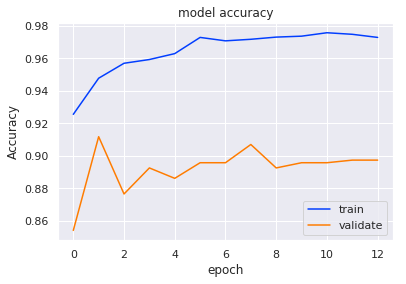

Epoch 1/30
163/163 [==============================] - 289s 2s/step - loss: 0.1066 - acc: 0.9584 - val_loss: 0.2743 - val_acc: 0.9087
Epoch 2/30
163/163 [==============================] - 274s 2s/step - loss: 0.1013 - acc: 0.9620 - val_loss: 0.2745 - val_acc: 0.9038
Epoch 3/30
163/163 [==============================] - 273s 2s/step - loss: 0.0993 - acc: 0.9609 - val_loss: 0.2846 - val_acc: 0.9006
Epoch 4/30
163/163 [==============================] - 274s 2s/step - loss: 0.0920 - acc: 0.9684 - val_loss: 0.2698 - val_acc: 0.9022
Epoch 5/30
163/163 [==============================] - 273s 2s/step - loss: 0.1004 - acc: 0.9611 - val_loss: 0.2645 - val_acc: 0.9087
Epoch 6/30
163/163 [==============================] - 276s 2s/step - loss: 0.0985 - acc: 0.9651 - val_loss: 0.2687 - val_acc: 0.9054
Epoch 7/30
163/163 [==============================] - 281s 2s/step - loss: 0.0950 - acc: 0.9645 - val_loss: 0.2835 - val_acc: 0.8942
Epoch 8/30
162/163 [============================>.] - ETA: 1s - loss:

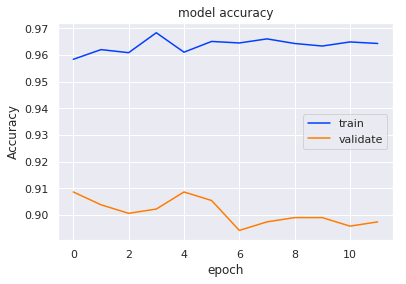

In [31]:
keep_training = True

def train_model():
  hist = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=30,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=test_generator,
                             validation_steps=len(test_generator),
                             class_weight=class_w)

  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validate'], loc='best')
  plt.show()

train_model()

if keep_training:
  # Improving Generalization Performance by Switching from Adam to SGD
  # https://arxiv.org/abs/1712.07628
  model.compile(SGD(learning_rate=1e-3, momentum=0.9),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  train_model()

In [32]:
vl_score = model.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.97      0.78      0.87       234
   Pneumonia       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.91      0.91      0.91       624

AUC:  0.8833333333333334


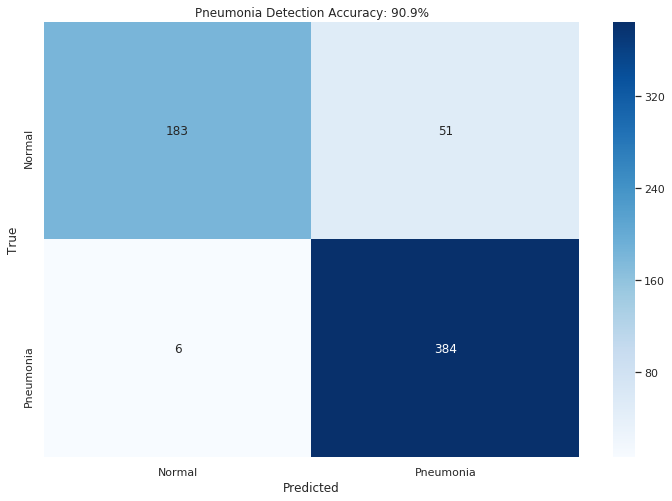

In [33]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [0]:
for l in range(len(model.layers)):
  if model.layers[l].name == 'attn_1':
    attn_1 = model.layers[l + 1]
  elif model.layers[l].name == 'attn_2':
    attn_2 = model.layers[l]
    break

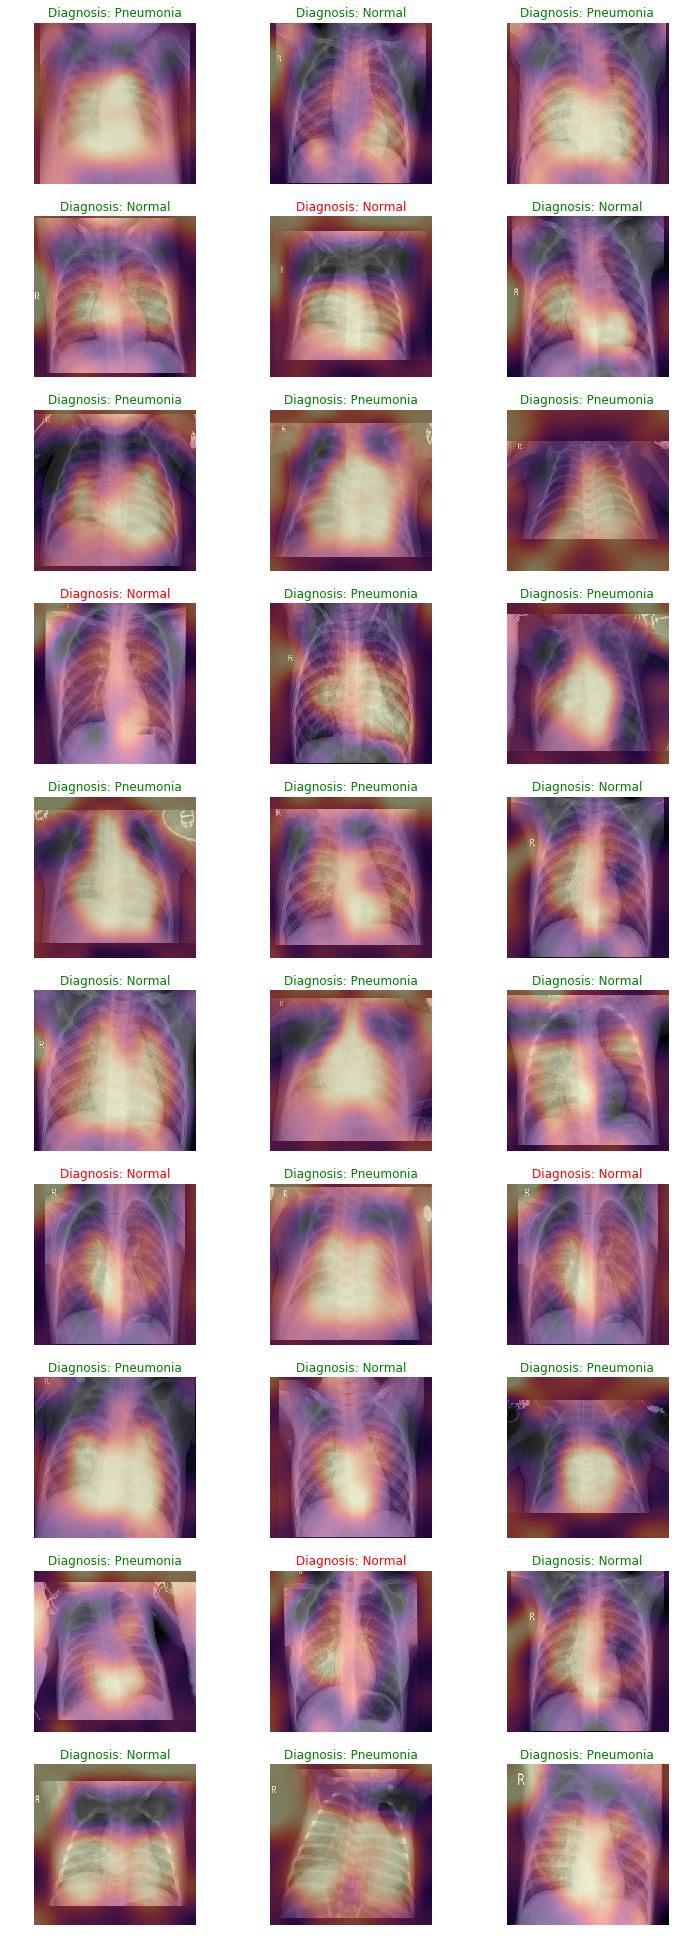

In [35]:
def third_pass(x, y):
    return (1 - x / 2 + x**5 + y**3) * np.exp(-(x**2 + y**2))

def plot_val_xrays(width=width//2, height=height//2,
                   rows=10, cols=3,
                   size_w=4, size_h=3.5):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  label_CM = {
    0: 'red',  # Incorrect diagnosis
    1: 'green' # Correct diagnosis
  }

  X_test_images, y_test_images = test_generator.next()

  attn_func_1 = K.function(inputs = [model.get_input_at(0), K.learning_phase()],
    outputs = [attn_1.get_output_at(0)]
  )

  attn_func_2 = K.function(inputs = [model.get_input_at(0), K.learning_phase()],
    outputs = [attn_2.get_output_at(0)]
  )

  for idx in range(0, rows*cols):
    i = random.randint(0, len(images_test))
    pred = np.round(vl_score[i][1])
    score = 1 if test_generator.classes[i] == pred else 0
    im_data = get_resized_image(images_test[i], 300, 225)

    im_data_xray = xray_process(im_data)
    attn_img_1 = attn_func_1(np.array([im_data_xray]))[0]
    attn_img_2 = attn_func_2(np.array([im_data_xray]))[0]
    attn_img = (attn_img_1 + attn_img_2) / 2
    attn_img = attn_img[0, :, :, 0]
        
    diagnosis_type = 'Pneumonia' if test_generator.classes[i] == 1 else 'Normal'
    diagnosis = 'Diagnosis: {}'.format(diagnosis_type)

    extent = 0, 1, 0, 1

    ax[idx//cols,idx%cols].imshow(im_data, cmap='gray_r', extent=extent)
    ax[idx//cols,idx%cols].imshow(attn_img, cmap='magma', vmin=0, vmax=1,
                                  extent=extent, alpha=0.5,
                                  interpolation='lanczos')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(diagnosis, color=label_CM[score])
  plt.show()

plot_val_xrays()